# Multi-modal (image) embeddings

## Install, import, initialize libraries and environment

In [86]:
%%writefile requirements.txt
google-cloud-aiplatform
google-cloud-storage
google-cloud-firestore
pywikibot

Overwriting requirements.txt


In [87]:
%pip install --user -qr requirements.txt

E0000 00:00:1732404388.546384      78 backup_poller.cc:126] Run client channel backup poller: UNKNOWN:pollset_work {created_time:"2024-11-23T23:26:28.546270355+00:00", children:[UNKNOWN:epoll_wait: Bad file descriptor (9) {created_time:"2024-11-23T23:26:28.546136425+00:00"}]}
Note: you may need to restart the kernel to use updated packages.


In [101]:
from typing import List

from dataclasses import dataclass, field
import pywikibot

from google.cloud import storage
from google.cloud import firestore
from google.cloud.firestore_v1.base_vector_query import DistanceMeasure
from google.cloud.firestore_v1.vector import Vector

import vertexai
from vertexai.vision_models import Image, MultiModalEmbeddingModel
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

from IPython.display import Image as PILImage

In [90]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[0]
LOCATION = 'us-west1'

In [8]:
vertexai.init(project=PROJECT_ID, location=LOCATION)

## Find images for embeddings

### Test the pywikibot API

In [3]:
site = pywikibot.Site('mediawiki:en')

In [8]:
results = site.search('Parthenon')
parthenon_files = list(results)[:20]

In [11]:
test_file = parthenon_files[0]
test_file.download()

True

In [18]:
test_file.title()

'File:Attica 06-13 Athens 50 View from Philopappos - Acropolis Hill.jpg'

### Download images locally

In [46]:
@dataclass
class DownloadedImage:
    city: str
    sight: str
    filename: str = ''
    gcs_uri: str = ''
    embeddings: List[float] = field(default_factory=lambda: [])
    
    def merge_embeddings(self, embeddings):
        self.embeddings.extend(embeddings)

In [81]:
searches = [
    DownloadedImage(city='Epidauros', sight='theatre'),
    DownloadedImage(city='Mycenae', sight='Lion Gate'),
    DownloadedImage(city='Crete', sight='Knossos'),
    DownloadedImage(city='Sparta', sight='Tomb of Leonidas'),
    DownloadedImage(city='Nafplion', sight='Palamidi'),
    DownloadedImage(city='Santorini', sight='Thera'),
    DownloadedImage(city='Athens', sight='Acropolis'),
    #DownloadedImage(city='Greece, Delphi', sight='ruins'), # Not good search results :/
]

In [82]:
exts = ["png", "jpg", "gif"]
for img in searches:
    search_results = site.search(f"{img.city} {img.sight}", total=1)
    file_page = list(search_results)

    if len(file_page) == 0:
        print("none found")
        continue

    file_page = file_page[0]
    file_ext = file_page.title().split(".")[-1]
    file_ext = file_ext.lower()
    
    if file_ext not in exts:
        print(file_page.title() + " is a not an image")
        continue
    
    new_file_name = f"downloads/{img.city} {img.sight}.{file_ext}".replace(" ", "_").replace(",", "_")
    new_file_name = new_file_name.lower()
    print(new_file_name)
    file_page.download(filename=new_file_name)
    img.filename = new_file_name

downloads/epidauros_theatre.jpg
downloads/mycenae_lion_gate.jpg
downloads/crete_knossos.jpg
downloads/sparta_tomb_of_leonidas.jpg
downloads/nafplion_palamidi.jpg
downloads/santorini_thera.jpg
downloads/athens_acropolis.jpg


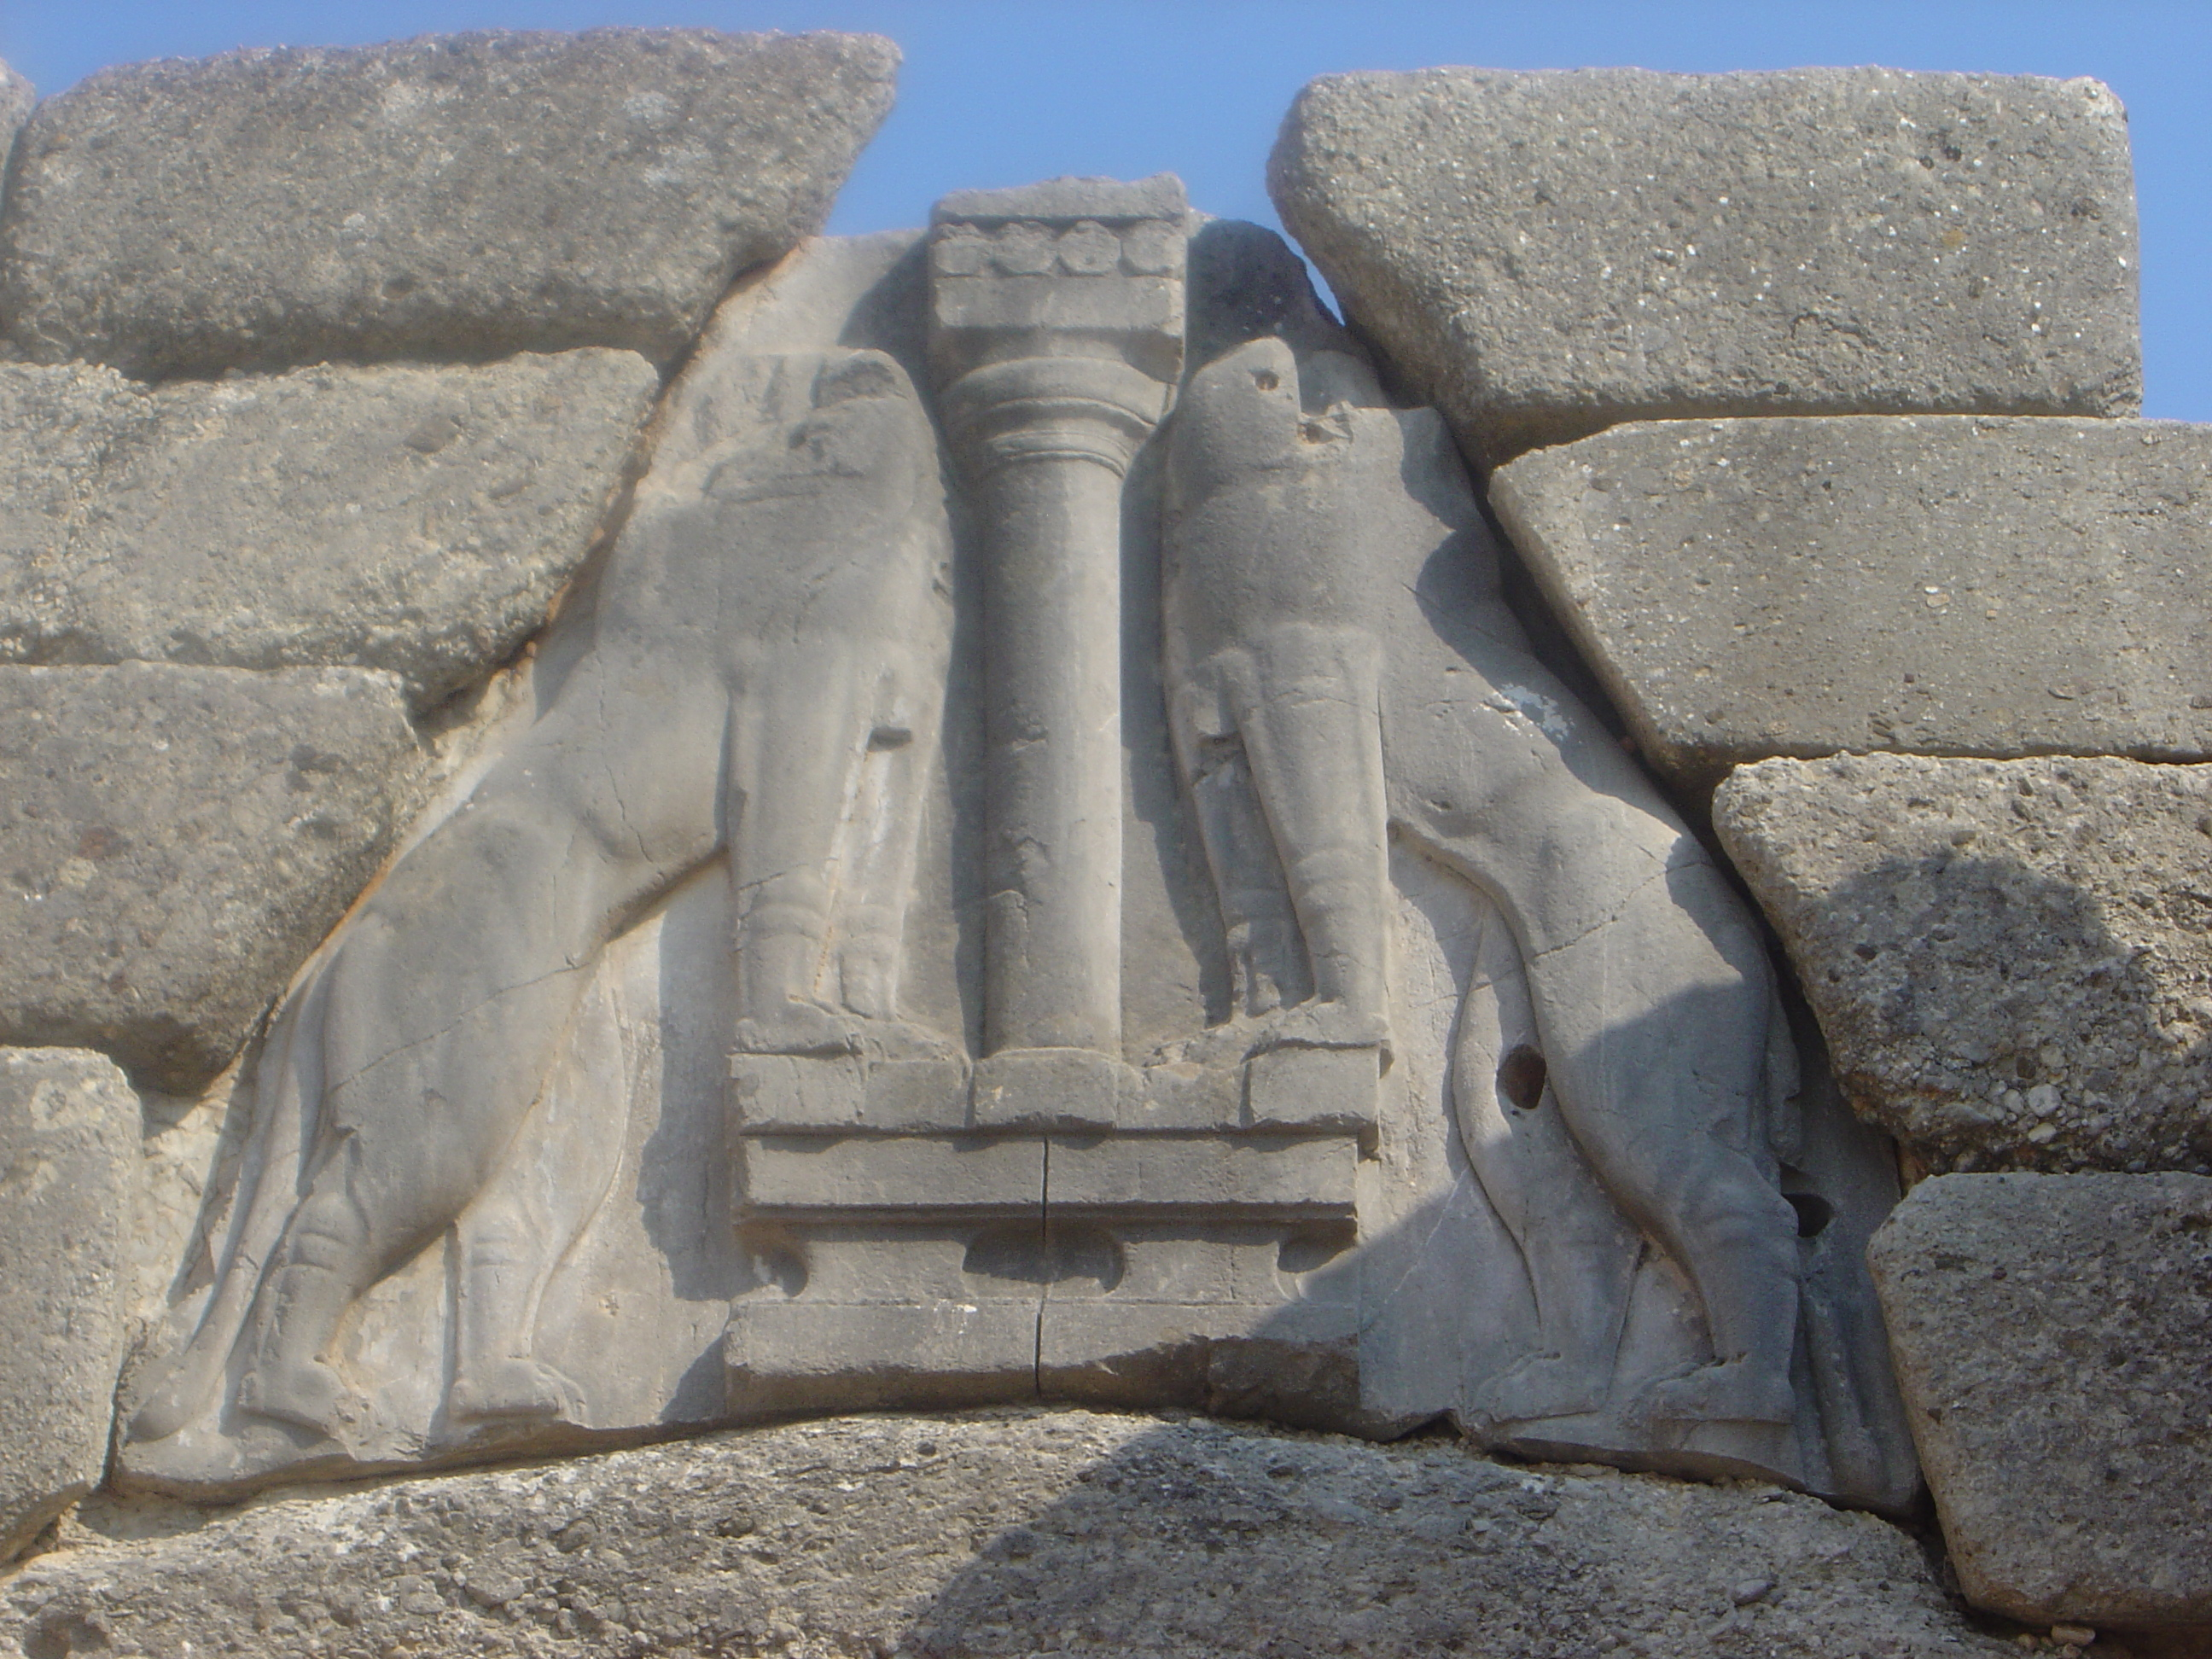

In [83]:
PILImage(filename="downloads/mycenae_lion_gate.jpg")

In [84]:
print(searches[0].__dict__)

{'city': 'Epidauros', 'sight': 'theatre', 'filename': 'downloads/epidauros_theatre.jpg', 'gcs_uri': '', 'embeddings': []}


## Create embeddings

### Test embeddings

In [73]:
embedding_dimensions = 128
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

test_search = searches[0]

image = Image.load_from_file(test_search.filename)

In [75]:
embeddings = model.get_embeddings(
    image=image,
    contextual_text=f"{test_search.city} {test_search.sight}",
    dimension=embedding_dimensions,
)

In [77]:
print(f"Image Embedding: {embeddings.image_embedding}")
print(f"Text Embedding: {embeddings.text_embedding}")

Image Embedding: [0.0706401393, -0.0316859633, -0.0400417298, 0.0317157172, -0.421568483, -0.00578523241, -0.0295007601, 0.00483708503, 0.030304756, 0.0457545407, -0.0081574358, -0.0054456, -0.0226556845, 0.0022535678, 0.0373910479, 0.0343622, -0.0152491946, 0.015513421, 0.0480729826, -0.0615171939, -0.0371451043, -0.0504079424, 0.0742316619, -0.00922389, 0.0144211724, -0.106781319, -0.0183115415, 0.316277653, 0.0410545915, -0.0367488451, -0.0764972121, 0.0880414844, -0.02246923, 0.00787342526, -0.0776472241, -0.0188151971, -0.119275048, 0.193285972, -0.0671949089, 0.0310230404, 0.07097774, -0.0539366901, 0.0318366624, 0.0439163595, 0.0309171807, -0.010822745, 0.0596977957, 0.0128502464, -0.00787016936, 0.00687820371, 0.0367881693, 0.108709618, 0.0341060162, 0.1191843, 0.073978588, 0.0389721841, 0.0731313154, 0.0448319353, 0.0785344616, 0.0204590112, -0.0746591, 0.0354175717, -0.0254343301, 0.0201594383, 0.0202989113, -0.0678289384, -0.0580772161, 0.0157747604, 0.0998443887, -0.0024613

In [78]:
test_search.merge_embeddings(embeddings.image_embedding)
test_search.merge_embeddings(embeddings.text_embedding)

In [79]:
test_search

DownloadedImage(city='Epidauros', sight='theatre', filename='downloads/epidauros_theatre.jpg', gcs_uri='', embeddings=[0.0706401393, -0.0316859633, -0.0400417298, 0.0317157172, -0.421568483, -0.00578523241, -0.0295007601, 0.00483708503, 0.030304756, 0.0457545407, -0.0081574358, -0.0054456, -0.0226556845, 0.0022535678, 0.0373910479, 0.0343622, -0.0152491946, 0.015513421, 0.0480729826, -0.0615171939, -0.0371451043, -0.0504079424, 0.0742316619, -0.00922389, 0.0144211724, -0.106781319, -0.0183115415, 0.316277653, 0.0410545915, -0.0367488451, -0.0764972121, 0.0880414844, -0.02246923, 0.00787342526, -0.0776472241, -0.0188151971, -0.119275048, 0.193285972, -0.0671949089, 0.0310230404, 0.07097774, -0.0539366901, 0.0318366624, 0.0439163595, 0.0309171807, -0.010822745, 0.0596977957, 0.0128502464, -0.00787016936, 0.00687820371, 0.0367881693, 0.108709618, 0.0341060162, 0.1191843, 0.073978588, 0.0389721841, 0.0731313154, 0.0448319353, 0.0785344616, 0.0204590112, -0.0746591, 0.0354175717, -0.0254343

### Get embeddings for all searched images

In [85]:
for s in searches:
    image = Image.load_from_file(s.filename)
    embeddings = model.get_embeddings(
        image=image,
        contextual_text=f"{s.city} {s.sight}",
        dimension=embedding_dimensions,
    )
    s.merge_embeddings(embeddings.image_embedding)
    s.merge_embeddings(embeddings.text_embedding)

## Store all images on GCS

In [91]:
storage_client = storage.Client(PROJECT_ID)
bucket = storage_client.bucket('myherodotus')

In [94]:
for s in searches:
    gcs_path = s.filename.replace("downloads", "images") 
    blob = bucket.blob(gcs_path)
    blob.upload_from_filename(s.filename)
    s.gcs_uri = f"gs://{gcs_path}"
    

## Create Firestore vector database

### Store all embeddings in Firestore

In [96]:
db = firestore.Client(PROJECT_ID, database='l200')
collection = db.collection('Embeddings')

In [97]:
for s in searches:
    new_doc_ref = collection.document()
    new_doc_ref.set(s.__dict__)

### Create the vector index

In [ ]:
!(gcloud firestore indexes composite create \
 --collection-group=Embeddings \
 --query-scope=COLLECTION \
 --field-config field-path=embeddings,vector-config='{"dimension":"128", "flat": "{}"}' \
 --database=l200) > /dev/null

### Test a vector query

In [102]:
query = "Sparta"

In [104]:
# Get embeddings vector from Vertex
model = TextEmbeddingModel.from_pretrained("text-embedding-005")
inputs = [TextEmbeddingInput(query, "RETRIEVAL_DOCUMENT")]

In [109]:
query_embeddings = model.get_embeddings(inputs, output_dimensionality=128)

In [113]:
query_results = query_embeddings[0]
print(query_results.values)

[-0.005313747562468052, -0.0006428670603781939, -0.0047108023427426815, 0.01363139133900404, 0.023272773250937462, 0.04159463196992874, -0.04054170474410057, 0.014760389924049377, -0.01582532748579979, -0.01222853921353817, -0.02696784771978855, -0.03773147240281105, -0.015906458720564842, 0.010733277536928654, -0.058118171989917755, 0.04165753349661827, 0.06146221607923508, -0.02604902721941471, -0.0014729188987985253, -0.001994169084355235, 0.025246204808354378, -0.10251850634813309, -0.09123103320598602, -0.04652079939842224, 0.03547868877649307, 0.005337779875844717, 0.009837426245212555, 0.009658800438046455, -0.009310761466622353, 0.016103962436318398, 0.060707367956638336, -0.03184168040752411, -0.03996682167053223, -0.012081395834684372, -0.025756757706403732, -0.02276701293885708, 0.032110270112752914, 0.0006267739809118211, 0.061739303171634674, 0.002102244645357132, 0.030621284618973732, 0.02071060612797737, 0.0036104866303503513, 0.020560825243592262, -0.0010850174585357308

In [119]:
# Find nearest neighbor in Firestore
vector_query = collection.find_nearest(
    vector_field="embeddings",
    query_vector=Vector(query_results.values),
    distance_measure=DistanceMeasure.EUCLIDEAN,
    limit=5,
)

In [120]:
docs = vector_query.stream()
for doc in docs:
    print(f"{doc.id} => {doc.to_dict()}")

## Sources

+ https://www.mediawiki.org/
+ https://pypi.org/project/pywikibot/#description
+ https://doc.wikimedia.org/pywikibot/stable/api_ref/pywikibot.page.html#page.FilePage
+ https://doc.wikimedia.org/pywikibot/stable/_modules/pywikibot.html#Site
+ https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-multimodal-embeddings
+ https://firebase.google.com/docs/firestore/vector-search#gcloud